##掛載雲端硬碟


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##複製Lab5檔案到目前目錄

In [3]:
!cp -a /content/drive/MyDrive/Colab\ Notebooks/* ./

## Import libarary

In [4]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg
import matplotlib.pyplot as plt

## 設定超參數(填空)

In [5]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
LAMBDA = 0.001
################################################


SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 120
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = True
START_EPOCH = 0
accuracy = []
iteration = []

WEIGHT_PATH = '/content/drive/MyDrive/Colab Notebooks/model_best.pth'


In [6]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


##下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [7]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


## 定義模型與載入訓練好的權重

In [8]:
model = vgg()
if CUDA:
    model.cuda()

##設定Optimizer，這裡使用Stocastic Gradient Descent

In [9]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

##使用論文中稀疏化的方式更新參數(填空)

In [10]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data))
          ################################################
          

## 載入預先定義好的模型與參數

In [11]:
# if(RESUME):
#   checkpoint = torch.load(WEIGHT_PATH)
#   model.load_state_dict(checkpoint['state_dict'])
#   optimizer.load_state_dict(checkpoint['optimizer'])
#   START_EPOCH = checkpoint['epoch']
#   best_prec1 = checkpoint['best_prec1']
#   print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

## 定義訓練跟測試函數

In [12]:
#### 訓練函數 #####
def train(epoch):
    model.train() 
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, size_average=False).data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      accuracy.append(100. * correct / len(test_loader.dataset))
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)
        
    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.317258
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.753687
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.472164
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.375302
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.424887


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.5636, Accuracy: 4758/10000 (47.6%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.302440
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.235095
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.381988
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.902186
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.248080

Test set: Average loss: 1.5406, Accuracy: 4603/10000 (46.0%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 1.189164
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 1.033186
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 1.011539
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 1.137749
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 1.350216

Test set: Average loss: 1.4752, Accuracy: 5239/10000 (52.4%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 1.238729
Train Epoch: 3 [10000/50000 (20.0%)]	Loss: 0.894574
Train Epoch: 3 [20000/50000 (40.0%)]	Loss: 0.919272
Train Epoch: 3 [30000/50000 (60.0%)]	Loss: 0.959775
Train Epoch: 3 [40000/50000 (80.0%)]	Loss: 0.806521

Test set: Average loss: 1.0171, Accuracy: 667

In [15]:
iteration = []
for i in range(120):
  iteration.append(i)

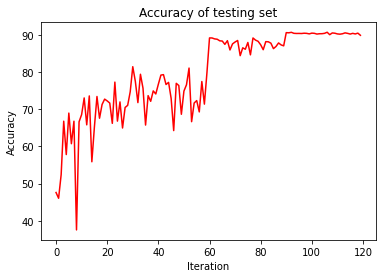

In [16]:
# plot accuracy and loss curves
plt.title("Accuracy of testing set")
plt.plot(iteration, accuracy, color="red")
plt.ylabel("Accuracy")
plt,plt.xlabel("Iteration")
plt.show()  